In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_1_multigrid_fixed'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 3e-6,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.1,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[150,100,80], log_std_init=-2.9),
                verbose = 1,
                target_kl = 0.05,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/coarse_grid_functions.py:51: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for j in range(len(p_1)-1):


Using cuda device
seed 1: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 15 x 15


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f7c46c67be0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f7c4680e5f8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.59 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.594    |
| time/              |          |
|    fps             | 106      |
|    iterations      | 1        |
|    time_elapsed    | 23       |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 54 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.597       |
| time/                   |             |
|    fps                  | 249         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| t

policy iteration runtime: 41 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.61 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.613       |
| time/                   |             |
|    fps                  | 251         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008958871 |
|    clip_fraction        | 0.33        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.785       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0713      |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.0256     |
|    std                  | 

policy iteration runtime: 38 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.639       |
| time/                   |             |
|    fps                  | 251         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009925622 |
|    clip_fraction        | 0.345       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.85        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0345      |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0258     |
|    std                  | 

policy iteration runtime: 41 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.65 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.654        |
| time/                   |              |
|    fps                  | 253          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0034764528 |
|    clip_fraction        | 0.344        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.864        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0396       |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.0268      |
|    std

policy iteration runtime: 39 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.66        |
| time/                   |             |
|    fps                  | 252         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006545782 |
|    clip_fraction        | 0.347       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.883       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0379      |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.0279     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 39 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.669       |
| time/                   |             |
|    fps                  | 250         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006781551 |
|    clip_fraction        | 0.353       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.888       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0703      |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.0269     |
|    std                  |

policy iteration runtime: 37 seconds

Total episode rollouts: 25088

seed 1: grid fidelity factor 0.5 learning ..
environement grid size (nx x ny ): 30 x 30


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f7c4680c080> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f7c468f89b0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.684       |
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1           |
|    time_elapsed         | 25          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004152441 |
|    clip_fraction        | 0.348       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.905       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.065       |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.0264     |
|    std                  | 0.0551      |
|    value_loss           | 0.00316     |
------------

policy iteration runtime: 37 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.684       |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006617397 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.879       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0411      |
|    n_updates            | 1140        |
|    policy_gradient_loss | -0.0305     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 45 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.686        |
| time/                   |              |
|    fps                  | 195          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0052358597 |
|    clip_fraction        | 0.352        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.893        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0282       |
|    n_updates            | 1300         |
|    policy_gradient_loss | -0.0293      |
|    std

policy iteration runtime: 45 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.687       |
| time/                   |             |
|    fps                  | 193         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007430819 |
|    clip_fraction        | 0.361       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.892       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0605      |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.0299     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 44 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.687       |
| time/                   |             |
|    fps                  | 194         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.003924498 |
|    clip_fraction        | 0.342       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.894       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0521      |
|    n_updates            | 1620        |
|    policy_gradient_loss | -0.0288     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 47 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.687       |
| time/                   |             |
|    fps                  | 187         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011865223 |
|    clip_fraction        | 0.372       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.895       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0478      |
|    n_updates            | 1780        |
|    policy_gradient_loss | -0.0302     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 42 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.688       |
| time/                   |             |
|    fps                  | 192         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006534028 |
|    clip_fraction        | 0.36        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.889       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0431      |
|    n_updates            | 1940        |
|    policy_gradient_loss | -0.0293     |
|    std                  |

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f7c46984208> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f7c4696cbe0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.695        |
| time/                   |              |
|    fps                  | 63           |
|    iterations           | 1            |
|    time_elapsed         | 40           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0073551508 |
|    clip_fraction        | 0.369        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.882        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0674       |
|    n_updates            | 1960         |
|    policy_gradient_loss | -0.0305      |
|    std                  | 0.0551       |
|    value_loss           | 0.0039

policy iteration runtime: 59 seconds

Total episode rollouts: 54272

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.696        |
| time/                   |              |
|    fps                  | 97           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0030741394 |
|    clip_fraction        | 0.351        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.826        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0555       |
|    n_updates            | 2120         |
|    policy_gradient_loss | -0.0295      |
|    std                  | 0.

policy iteration runtime: 54 seconds

Total episode rollouts: 58368

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.696       |
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004943478 |
|    clip_fraction        | 0.364       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.841       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0415      |
|    n_updates            | 2280        |
|    policy_gradient_loss | -0.0308     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 58 seconds

Total episode rollouts: 62464

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 1           |
|    time_elapsed         | 25          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004147166 |
|    clip_fraction        | 0.366       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.848       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0826      |
|    n_updates            | 2440        |
|    policy_gradient_loss | -0.0304     |
|    std                  |

policy iteration runtime: 54 seconds

Total episode rollouts: 66560

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.697      |
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 1          |
|    time_elapsed         | 26         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00717383 |
|    clip_fraction        | 0.376      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.852      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0486     |
|    n_updates            | 2600       |
|    policy_gradient_loss | -0.032     |
|    std                  | 0.055      |
|    value_loss           |

policy iteration runtime: 59 seconds

Total episode rollouts: 70656

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009552089 |
|    clip_fraction        | 0.362       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.862       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.054       |
|    n_updates            | 2760        |
|    policy_gradient_loss | -0.0305     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 57 seconds

Total episode rollouts: 74752

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005275327 |
|    clip_fraction        | 0.382       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.865       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0427      |
|    n_updates            | 2920        |
|    policy_gradient_loss | -0.0316     |
|    std                  | 0.055       |
|    va

<IPython.core.display.Javascript object>


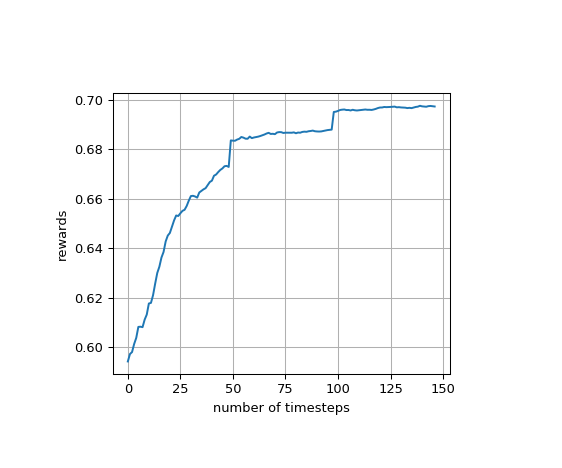

Using cuda device
seed 2: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 15 x 15


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f7c46968780> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f7c468c92b0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.601       |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009514904 |
|    clip_fraction        | 0.363       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.86        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0583      |
|    n_updates            | 2940        |
|    policy_gradient_loss | -0.0294     |
|    std                  | 0.055       |
|    value_loss           | 0.00473     |
------------

policy iteration runtime: 41 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.62       |
| time/                   |            |
|    fps                  | 237        |
|    iterations           | 1          |
|    time_elapsed         | 10         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.01039381 |
|    clip_fraction        | 0.336      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.799      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.049      |
|    n_updates            | 160        |
|    policy_gradient_loss | -0.0251    |
|    std                  | 0.055      |
|    v

policy iteration runtime: 42 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.64 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.641        |
| time/                   |              |
|    fps                  | 228          |
|    iterations           | 1            |
|    time_elapsed         | 11           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0070581674 |
|    clip_fraction        | 0.346        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.839        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0589       |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0261      |
|    std 

policy iteration runtime: 42 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.659       |
| time/                   |             |
|    fps                  | 231         |
|    iterations           | 1           |
|    time_elapsed         | 11          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007250157 |
|    clip_fraction        | 0.332       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.863       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.065       |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0254     |
|    std                  |

policy iteration runtime: 43 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.663       |
| time/                   |             |
|    fps                  | 227         |
|    iterations           | 1           |
|    time_elapsed         | 11          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007168728 |
|    clip_fraction        | 0.345       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.881       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0417      |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.0273     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 43 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.668       |
| time/                   |             |
|    fps                  | 242         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.006884399 |
|    clip_fraction        | 0.336       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.893       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.078       |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0265     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 39 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.671        |
| time/                   |              |
|    fps                  | 240          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0053995075 |
|    clip_fraction        | 0.342        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.898        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0741       |
|    n_updates            | 960          |
|    policy_gradient_loss | -0.0275      |
|    std

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f7c470d1b00> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f7c468f85c0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.684       |
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005432823 |
|    clip_fraction        | 0.352       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.89        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.055       |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.0278     |
|    std                  | 0.0551      |
|    value_loss           | 0.00375     |
------------

policy iteration runtime: 46 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.687       |
| time/                   |             |
|    fps                  | 186         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004346752 |
|    clip_fraction        | 0.328       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.868       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0951      |
|    n_updates            | 1140        |
|    policy_gradient_loss | -0.0266     |
|    std                  |

policy iteration runtime: 45 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.688       |
| time/                   |             |
|    fps                  | 184         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011078197 |
|    clip_fraction        | 0.363       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.883       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.059       |
|    n_updates            | 1300        |
|    policy_gradient_loss | -0.03       |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 44 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.689       |
| time/                   |             |
|    fps                  | 186         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007947365 |
|    clip_fraction        | 0.36        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.894       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0655      |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.0305     |
|    std                  | 0.0551      |
|    va

policy iteration runtime: 45 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 5             |
|    mean_reward          | 0.69          |
| time/                   |               |
|    fps                  | 183           |
|    iterations           | 1             |
|    time_elapsed         | 13            |
|    total_timesteps      | 2560          |
| train/                  |               |
|    approx_kl            | 0.00046337844 |
|    clip_fraction        | 0.36          |
|    clip_range           | 0.1           |
|    entropy_loss         | 91.8          |
|    explained_variance   | 0.893         |
|    learning_rate        | 3e-06         |
|    loss                 | 0.0397        |
|    n_updates            | 1620          |
|    policy_gradient_loss | -0.0289       |
|    std   

policy iteration runtime: 47 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.69       |
| time/                   |            |
|    fps                  | 187        |
|    iterations           | 1          |
|    time_elapsed         | 13         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00638701 |
|    clip_fraction        | 0.358      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.898      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0673     |
|    n_updates            | 1780       |
|    policy_gradient_loss | -0.0294    |
|    std                  | 0.0551     |
|    value_loss           |

policy iteration runtime: 46 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.69        |
| time/                   |             |
|    fps                  | 185         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010209605 |
|    clip_fraction        | 0.364       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.898       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0993      |
|    n_updates            | 1940        |
|    policy_gradient_loss | -0.0297     |
|    std                  |

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f7c468f85c0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f7c140e0eb8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 62          |
|    iterations           | 1           |
|    time_elapsed         | 40          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005984756 |
|    clip_fraction        | 0.364       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.898       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0512      |
|    n_updates            | 1960        |
|    policy_gradient_loss | -0.0297     |
|    std                  | 0.055       |
|    value_loss           | 0.00355     |
------------

policy iteration runtime: 54 seconds

Total episode rollouts: 54272

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.697        |
| time/                   |              |
|    fps                  | 98           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0035756498 |
|    clip_fraction        | 0.364        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.838        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0665       |
|    n_updates            | 2120         |
|    policy_gradient_loss | -0.0297      |
|    std                  | 0.

policy iteration runtime: 53 seconds

Total episode rollouts: 58368

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.010969537 |
|    clip_fraction        | 0.358       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.835       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.07        |
|    n_updates            | 2280        |
|    policy_gradient_loss | -0.0306     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 57 seconds

Total episode rollouts: 62464

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.697       |
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.004477772 |
|    clip_fraction        | 0.364       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.844       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0561      |
|    n_updates            | 2440        |
|    policy_gradient_loss | -0.0298     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 58 seconds

Total episode rollouts: 66560

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.698        |
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0049616545 |
|    clip_fraction        | 0.371        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.847        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0653       |
|    n_updates            | 2600         |
|    policy_gradient_loss | -0.0313      |
|    std

policy iteration runtime: 56 seconds

Total episode rollouts: 70656

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.698        |
| time/                   |              |
|    fps                  | 97           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0071435184 |
|    clip_fraction        | 0.366        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.844        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0497       |
|    n_updates            | 2760         |
|    policy_gradient_loss | -0.0301      |
|    std                  | 0.

policy iteration runtime: 57 seconds

Total episode rollouts: 74752

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.697        |
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0073684095 |
|    clip_fraction        | 0.363        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.851        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0294       |
|    n_updates            | 2920         |
|    policy_gradient_loss | -0.0295      |
|    std                  | 0.

<IPython.core.display.Javascript object>


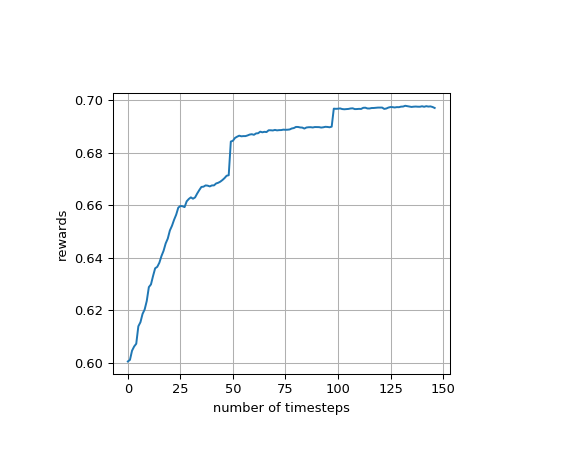

Using cuda device
seed 3: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 15 x 15


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f7c140e0208> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f7c14092828>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.60 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.599        |
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 1            |
|    time_elapsed         | 23           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0033539473 |
|    clip_fraction        | 0.361        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.85         |
|    learning_rate        | 3e-06        |
|    loss                 | 0.083        |
|    n_updates            | 2940         |
|    policy_gradient_loss | -0.0298      |
|    std                  | 0.055        |
|    value_loss           | 0.0050

policy iteration runtime: 39 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.62 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.616       |
| time/                   |             |
|    fps                  | 246         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011999324 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.79        |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0322      |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0254     |
|    std                  | 

policy iteration runtime: 42 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.63 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.63         |
| time/                   |              |
|    fps                  | 244          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0060845404 |
|    clip_fraction        | 0.333        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.858        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0552       |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0245      |
|    std 

policy iteration runtime: 39 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.65 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.646       |
| time/                   |             |
|    fps                  | 238         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007718435 |
|    clip_fraction        | 0.342       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.876       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0752      |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0253     |
|    std                  |

policy iteration runtime: 38 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.66 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
--------------------------------------------
| eval/                   |                |
|    mean_ep_length       | 5              |
|    mean_reward          | 0.659          |
| time/                   |                |
|    fps                  | 247            |
|    iterations           | 1              |
|    time_elapsed         | 10             |
|    total_timesteps      | 2560           |
| train/                  |                |
|    approx_kl            | -0.00017822385 |
|    clip_fraction        | 0.35           |
|    clip_range           | 0.1            |
|    entropy_loss         | 91.8           |
|    explained_variance   | 0.9            |
|    learning_rate        | 3e-06          |
|    loss                 | 0.0868         |
|    n_updates            | 640            |
|    policy_gra

policy iteration runtime: 42 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.666       |
| time/                   |             |
|    fps                  | 253         |
|    iterations           | 1           |
|    time_elapsed         | 10          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.011829317 |
|    clip_fraction        | 0.359       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.908       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0601      |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0271     |
|    std                  |

policy iteration runtime: 42 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.671        |
| time/                   |              |
|    fps                  | 254          |
|    iterations           | 1            |
|    time_elapsed         | 10           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0061362833 |
|    clip_fraction        | 0.351        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.907        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0765       |
|    n_updates            | 960          |
|    policy_gradient_loss | -0.0268      |
|    std

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f7c140acb70> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f7c140ef080>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.682        |
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0065400093 |
|    clip_fraction        | 0.349        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.911        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0587       |
|    n_updates            | 980          |
|    policy_gradient_loss | -0.027       |
|    std                  | 0.0551       |
|    value_loss           | 0.0031

policy iteration runtime: 44 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.685      |
| time/                   |            |
|    fps                  | 187        |
|    iterations           | 1          |
|    time_elapsed         | 13         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00806571 |
|    clip_fraction        | 0.351      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.881      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0456     |
|    n_updates            | 1140       |
|    policy_gradient_loss | -0.0294    |
|    std                  | 0.0551     |
|    

policy iteration runtime: 45 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.687       |
| time/                   |             |
|    fps                  | 188         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.005053279 |
|    clip_fraction        | 0.365       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.899       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0613      |
|    n_updates            | 1300        |
|    policy_gradient_loss | -0.0292     |
|    std                  |

policy iteration runtime: 46 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.687      |
| time/                   |            |
|    fps                  | 188        |
|    iterations           | 1          |
|    time_elapsed         | 13         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.00402942 |
|    clip_fraction        | 0.353      |
|    clip_range           | 0.1        |
|    entropy_loss         | 91.8       |
|    explained_variance   | 0.899      |
|    learning_rate        | 3e-06      |
|    loss                 | 0.0561     |
|    n_updates            | 1460       |
|    policy_gradient_loss | -0.0276    |
|    std                  | 0.0551     |
|    value_loss           |

policy iteration runtime: 45 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.688        |
| time/                   |              |
|    fps                  | 188          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0038785995 |
|    clip_fraction        | 0.356        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.901        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0797       |
|    n_updates            | 1620         |
|    policy_gradient_loss | -0.0287      |
|    std                  | 0.

policy iteration runtime: 46 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.689       |
| time/                   |             |
|    fps                  | 189         |
|    iterations           | 1           |
|    time_elapsed         | 13          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.009721969 |
|    clip_fraction        | 0.381       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.908       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0487      |
|    n_updates            | 1780        |
|    policy_gradient_loss | -0.0302     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 45 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.69 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.689        |
| time/                   |              |
|    fps                  | 185          |
|    iterations           | 1            |
|    time_elapsed         | 13           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0042210966 |
|    clip_fraction        | 0.35         |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.906        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.068        |
|    n_updates            | 1940         |
|    policy_gradient_loss | -0.0274      |
|    std

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f7bfc1d2dd8> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f7bfc1d9208>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.698       |
| time/                   |             |
|    fps                  | 64          |
|    iterations           | 1           |
|    time_elapsed         | 39          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008315107 |
|    clip_fraction        | 0.366       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.905       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0541      |
|    n_updates            | 1960        |
|    policy_gradient_loss | -0.0285     |
|    std                  | 0.055       |
|    value_loss           | 0.00334     |
------------

policy iteration runtime: 48 seconds

Total episode rollouts: 54272

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.698       |
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 1           |
|    time_elapsed         | 25          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.008907447 |
|    clip_fraction        | 0.35        |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.854       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0857      |
|    n_updates            | 2120        |
|    policy_gradient_loss | -0.0295     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 57 seconds

Total episode rollouts: 58368

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.699       |
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 1           |
|    time_elapsed         | 26          |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.007975864 |
|    clip_fraction        | 0.377       |
|    clip_range           | 0.1         |
|    entropy_loss         | 91.8        |
|    explained_variance   | 0.865       |
|    learning_rate        | 3e-06       |
|    loss                 | 0.0537      |
|    n_updates            | 2280        |
|    policy_gradient_loss | -0.0317     |
|    std                  | 0.055       |
|    va

policy iteration runtime: 53 seconds

Total episode rollouts: 62464

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.698        |
| time/                   |              |
|    fps                  | 97           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0058136196 |
|    clip_fraction        | 0.361        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.8         |
|    explained_variance   | 0.868        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0884       |
|    n_updates            | 2440         |
|    policy_gradient_loss | -0.0297      |
|    std                  | 0.

policy iteration runtime: 47 seconds

Total episode rollouts: 66560

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.699        |
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0066993446 |
|    clip_fraction        | 0.356        |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.879        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0434       |
|    n_updates            | 2600         |
|    policy_gradient_loss | -0.0288      |
|    std

policy iteration runtime: 57 seconds

Total episode rollouts: 70656

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.699        |
| time/                   |              |
|    fps                  | 98           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0033142031 |
|    clip_fraction        | 0.37         |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.875        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0598       |
|    n_updates            | 2760         |
|    policy_gradient_loss | -0.0306      |
|    std

policy iteration runtime: 51 seconds

Total episode rollouts: 74752

Eval num_timesteps=2560, episode_reward=0.70 +/- 0.00
Episode length: 5.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 5            |
|    mean_reward          | 0.699        |
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 1            |
|    time_elapsed         | 26           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 0.0052112043 |
|    clip_fraction        | 0.37         |
|    clip_range           | 0.1          |
|    entropy_loss         | 91.9         |
|    explained_variance   | 0.877        |
|    learning_rate        | 3e-06        |
|    loss                 | 0.0938       |
|    n_updates            | 2920         |
|    policy_gradient_loss | -0.0299      |
|    std                  | 0.

<IPython.core.display.Javascript object>


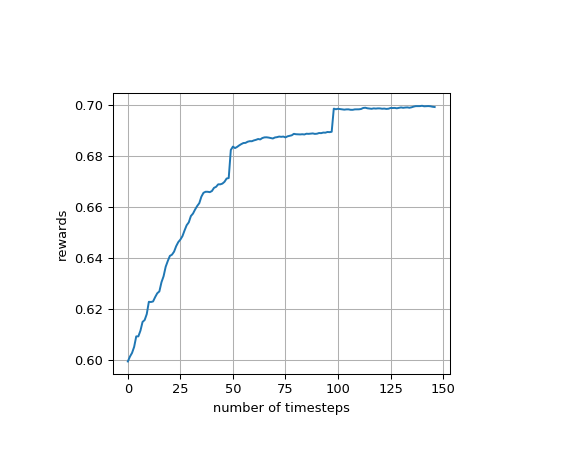

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.2, 
                                n=np.inf,
                                grid_fidelity_factor_array =[0.25, 0.5, 1.0],
                                episode_limit_array=[25000, 25000, 25000], 
                                log_dir=log_dir,
                                seed=seed)